<div style="width:100%; overflow:hidden; background-color:#F1F1E6; padding: 10px; border-style: outset; color:#17469e">
    <div style="width: 80%; float: left;">
    <h2 align="center">Universidad de Sonora</h2>
    <hr style="border-width: 3px; border-color:#17469e">
          <h1>Reconocimiento de patrones: Preparación de los datos</h1>          
          <h4>Ramón Soto C. <a href="mailto:rsotoc@moviquest.com/">(rsotoc@moviquest.com)</a></h4>
    </div>
    <div style="float: right;">
    <img src="images/escudo_unison.png">
    </div>
</div>

## Caso de estudio: [*Stack Overflow 2018 Developer Survey*](https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey)

Como caso de estudio principal en el presente curso hemos seleccionado la encuesta de desarrolladores 2018 de *Stack Overflow* disponible en [Kaggle](https://www.kaggle.com). En este esta etapa realizaremos el análisis de agrupamientos.

### 4. Modelado - Dendrogramas

<div style="margin-top: 6px; border: 1px solid #cfcfcf; padding: 8px 12px; border-radius:2px; background-color:#f7f7f7; ">
La primera fase del modelado, en este caso particular donde no tenemos información de las categorías subyacentes en la muestra, consiste en identificar los potenciales agrupamientos.<br><br> 
La primera técnica que emplearemos para este fin es la identificación de clusters mediante Dendrogramas.<br><br> 
El primer problema que tenemos que resolver es como medir distancias entre los tipos de datos específicos. Utilizamos una medida de distancia de Gower para datos híbridos.
</div>

In [1]:
"""
Reconocimiento de patrones: Dendrogramas
"""

import pandas as pd
import numpy as np
import json
import pickle

from collections import Counter
from operator import itemgetter
from IPython.display import display, HTML

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

pd.set_option('display.max_columns', 130)
pd.set_option('max_colwidth', 80)

In [2]:
path = "Data sets/Stack Overflow Survey/"

# Recuperar encabezados de columnas en orden original
with open(path + 'survey_results_public_transformed.headers', 'rb') as file:  
    headers = pickle.load(file)

# Recuperar diccionarios... sólo por si se requieren
with open(path + 'survey_results_public_transformed.dicts', 'rb') as file:  
    dict_of_dicts = pickle.load(file)

with open(path + 'survey_results_public_transformed.json') as f:
    dict_json = json.load(f)
df = pd.DataFrame.from_dict(dict_json)

# Reordenar las columnas de acuerdo al orden original
df = df.reindex(headers, axis=1)

In [3]:
var_str = ['Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation', 
         'UndergradMajor', 'CompanySize', 'YearsCoding', 'YearsCodingProf', 'UpdateCV', 
         'JobSatisfaction', 'CareerSatisfaction', 'HopeFiveYears', 'JobSearchStatus', 
         'LastNewJob', 'TimeFullyProductive', 'AgreeDisagree1', 'AgreeDisagree2', 
         'AgreeDisagree3', 'OperatingSystem', 'NumberMonitors', 'CheckInCode', 'AdBlocker', 
         'AdBlockerDisable', 'AdsAgreeDisagree1', 'AdsAgreeDisagree2', 'AdsAgreeDisagree3', 
         'AIDangerous', 'AIInteresting', 'AIResponsible', 'AIFuture', 'EthicsChoice', 
         'EthicsReport', 'EthicsResponsible', 'EthicalImplications', 'HoursComputer', 
         'StackOverflowRecommend', 'StackOverflowVisit', 'StackOverflowHasAccount', 
         'StackOverflowParticipate', 'StackOverflowJobs', 'StackOverflowDevStory', 
         'StackOverflowJobsRecommend', 'StackOverflowConsiderMember', 'HypotheticalTools1', 
         'HypotheticalTools2', 'HypotheticalTools3', 'HypotheticalTools4', 'WakeTime', 
         'HypotheticalTools5', 'HoursOutside', 'SkipMeals', 'Exercise', 'EducationParents', 
         'Age', 'Dependents', 'SurveyTooLong', 'SurveyEasy']
var_list = ['DevType', 'CommunicationTools', 'EducationTypes', 'SelfTaughtTypes', 
         'HackathonReasons', 'LanguageDesireNextYear', 'DatabaseWorkedWith', 
         'DatabaseDesireNextYear', 'PlatformWorkedWith', 'PlatformDesireNextYear', 
         'FrameworkWorkedWith', 'FrameworkDesireNextYear', 'IDE', 'Methodology', 
         'VersionControl', 'AdBlockerReasons', 'AdsActions', 'ErgonomicDevices', 
         'RaceEthnicity', 'LanguageWorkedWith']
var_ranks = ['AssessJob', 'AssessBenefits', 'JobContactPriorities', 'JobEmailPriorities', 
             'AdsPriorities']
var_float = 'ConvertedSalary'

def distance_qual(x, y):
    # Número de variables; si var_float es array, modificar "+ 1" por "+ len(var_float)"
    numvars = len(var_str) + len(var_list) + len(var_ranks) + 1
    
    distancia = abs(x.ConvertedSalary - y.ConvertedSalary)
    if pd.isnull(distancia):
        distancia = 0
        numvars -= 1
        
    for col in var_str:
        if x[col] != y[col]:
            distancia += 1
        
    for col in var_list:
        num_vars = len(x[col]) + len(y[col])
        d = 0
        if num_vars > 0:
            d = (2*len(set(x[col] + y[col])) - num_vars) / num_vars
        distancia += d

    for col in var_ranks:
        d = 0
        max_vars = max(len(x[col]), len(y[col]))
        if len(x[col]) != 0 and len(y[col]) != 0:
            for v in range(len(x[col])):
                if x[col][v] != y[col][v]:
                    d += 1
        else:
            d += max_vars
        
        if d != 0:
            d /= max_vars
        distancia += d
        
        #print(col, x[col], y[col], d)

    return distancia / numvars

def distance_matrix(rows):
    list_array = []
    for index, row in rows.iterrows():
        for i in range(index + 1, rows.shape[0]):
            list_array.append(distance_qual(rows.iloc[index], rows.iloc[i]))
#    print(list_array)
#    print(squareform(list_array))

    return list_array # matriz triangular superior

def display_tree(X, dend_type, clusters=10):
    Z = linkage(X, dend_type)
    plt.figure(figsize=(12, 5))
    dendrogram(Z,     
               truncate_mode='lastp',
               p=clusters, 
               show_leaf_counts=True,  
               leaf_font_size=14)
    plt.show()

<div style="margin-top: 6px; border: 1px solid #cfcfcf; padding: 8px 12px; border-radius:2px; background-color:#f7f7f7; ">
Un problema específico de los dendrogramas es que hay que calcular la matriz de distancias, lo cual es, en principio, una matriz de todos los datos contra los restantes. Dado que es una matriz triangular, con valores cero en la diagonal, los cálculos se reducen a $n_d=\frac{1}{2} n_e \times (n_e -1)$, siendo $n_d$ el número de distancias que debn calcularse y $ne$ el número de elementos de la muestra. Esta cantidad de cálculos es aún elevado para una base de datos como la de la encuesta, como puede apreciarse de la siguiente exploración:
</div>

In [4]:
import time

total_dists = df.shape[0] * (df.shape[0] - 1) / 2

df1 = df.sample(n=1000).reset_index(drop=True)
start_time = time.time()
X = distance_matrix(df1)
elapsed_time = time.time() - start_time

print("Número de distancias calculadas:", len(X), 
     "\nTiempo empleado (segundos):", elapsed_time,
     "\nTiempo unitario promedio:", elapsed_time / len(X),
      "\n\nTotal de distancia a calcular:", total_dists, 
     "\nTiempo total para el conjunto de datos (dias):", 
      elapsed_time / len(X) * total_dists / 86400)

Número de distancias calculadas: 499500 
Tiempo empleado (segundos): 1419.8195068836212 
Tiempo unitario promedio: 0.002842481495262505 

Total de distancia a calcular: 4845462903.0 
Tiempo total para el conjunto de datos (dias): 159.41132682590785


<div style="margin-top: 6px; border: 1px solid #cfcfcf; padding: 8px 12px; border-radius:2px; background-color:#f7f7f7; ">
Como puede apreciarse, el cálculo de la matriz triangular es muy costosa. En lugar de hacer la exploración completa, haremos una serie de exploraciones con muestreos aleatorios:
</div>

Corrida 0 - 'single'


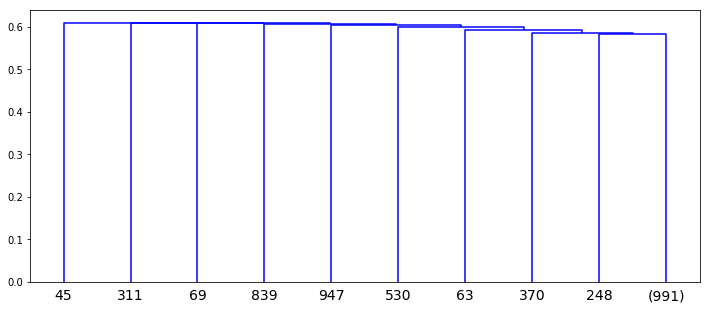

Corrida 0 - 'complete'


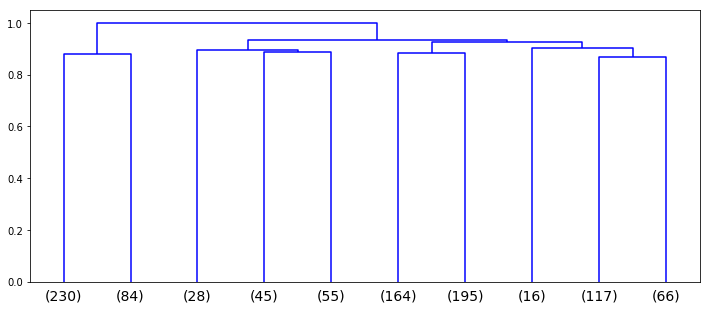

Corrida 0 - 'weighted'


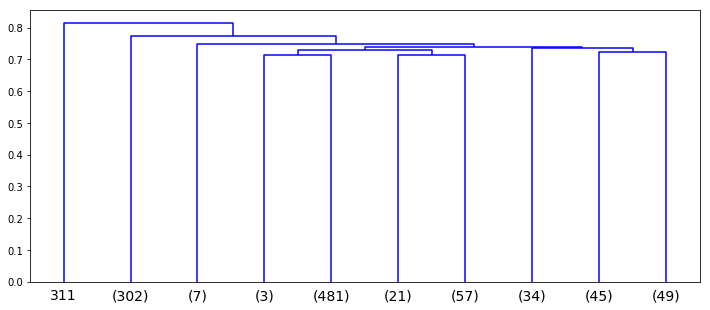

Corrida 1 - 'single'


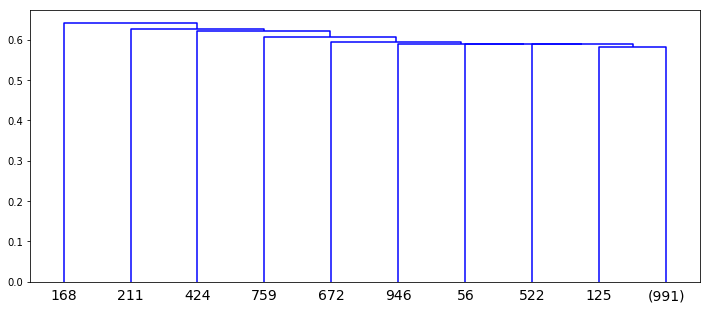

Corrida 1 - 'complete'


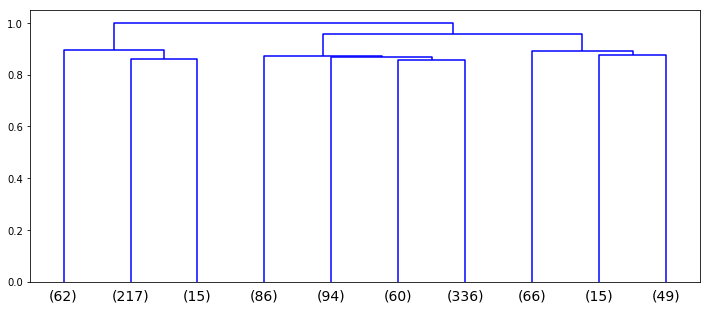

Corrida 1 - 'weighted'


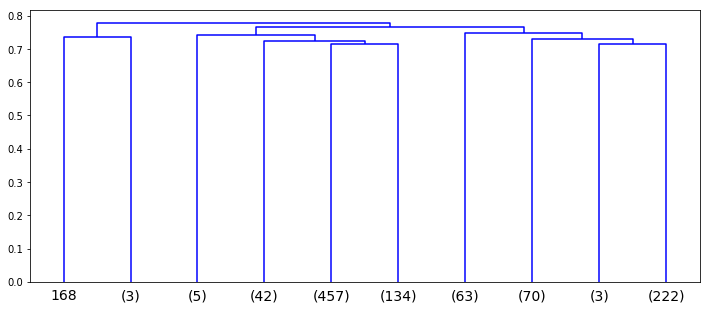

Corrida 2 - 'single'


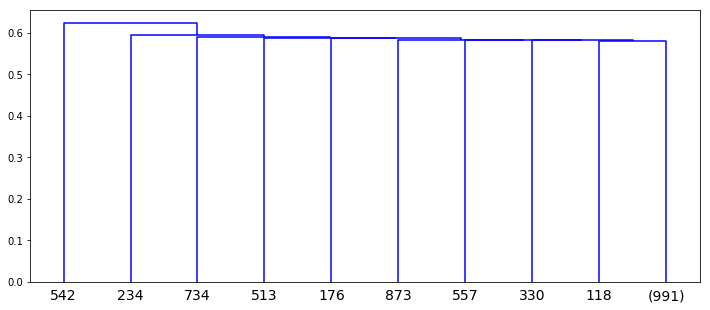

Corrida 2 - 'complete'


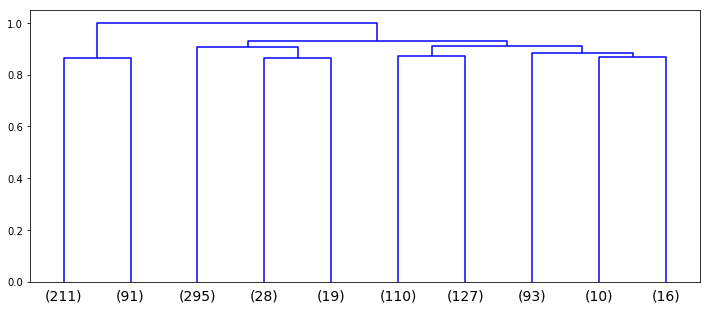

Corrida 2 - 'weighted'


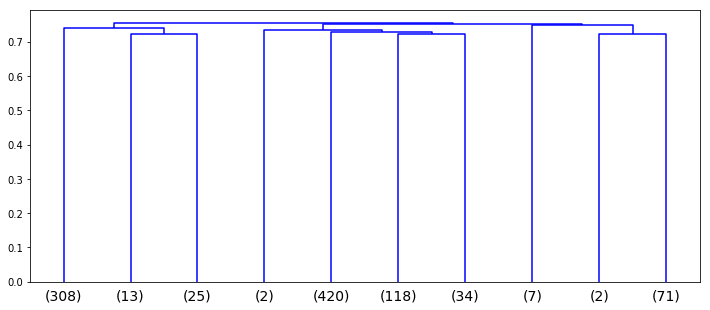

Corrida 3 - 'single'


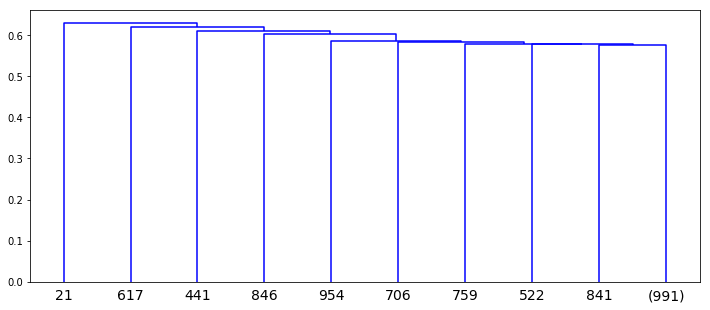

Corrida 3 - 'complete'


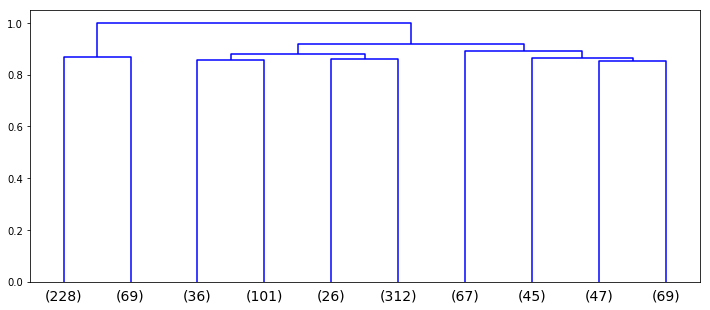

Corrida 3 - 'weighted'


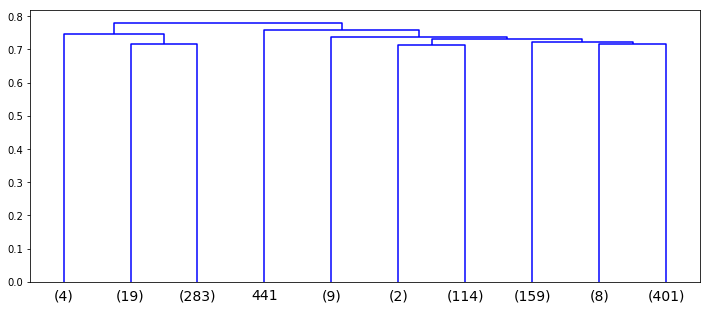

Corrida 4 - 'single'


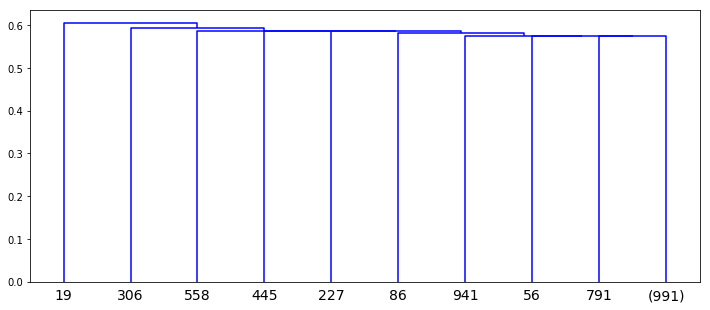

Corrida 4 - 'complete'


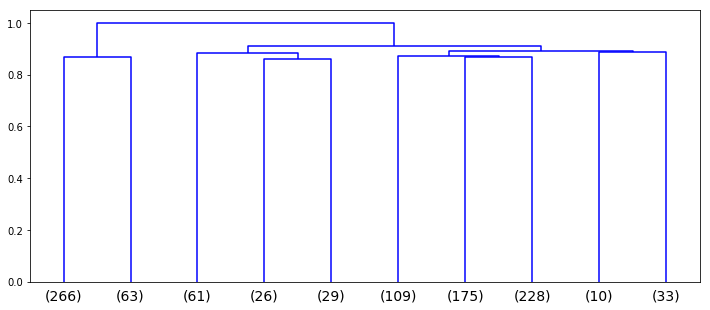

Corrida 4 - 'weighted'


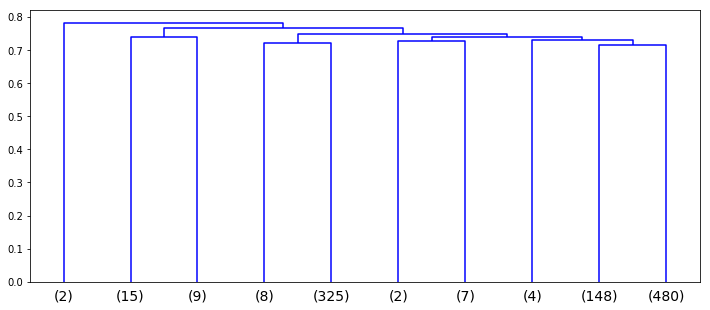

Corrida 5 - 'single'


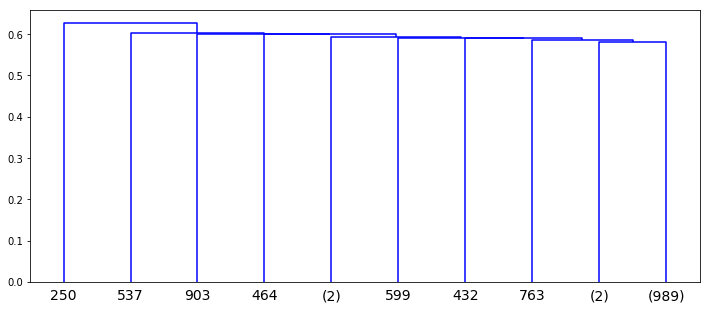

Corrida 5 - 'complete'


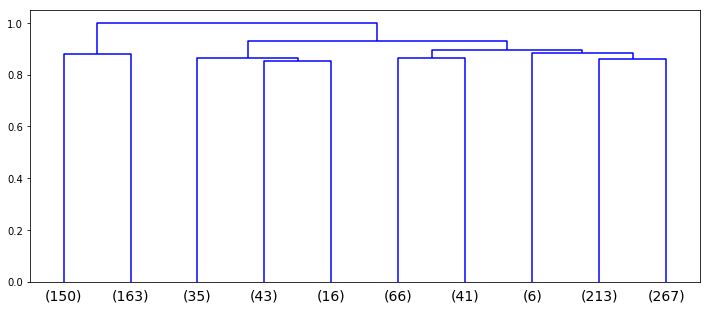

Corrida 5 - 'weighted'


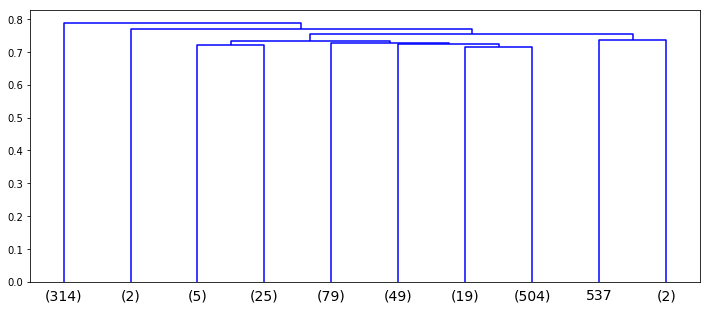

In [6]:
for i in range(6):
    df1 = df.sample(n=1000).reset_index(drop=True)
    X = distance_matrix(df1)
    corrida = "Corrida " + str(i)
    
    print(str(corrida) + " - " + "'single'")
    display_tree(X, 'single')
    display(HTML('<hr style="border-width: 3px;">'))
    print(str(corrida) + " - " + "'complete'")
    display_tree(X, 'complete')
    display(HTML('<hr style="border-width: 3px;">'))
    print(str(corrida) + " - " + "'weighted'")
    display_tree(X, 'weighted')
    display(HTML('<hr style="border-width: 5px;"><br><br>'))

<div style="margin-top: 6px; border: 1px solid #cfcfcf; padding: 8px 12px; border-radius:2px; background-color:#f7f7f7;">
Los dendrogramas anteriores muestran, al nivel explorado, 2 o tres grandes grupos. Analicemos un mayor grado de agrupamientos:
</div>

Corrida 0 - 'single'


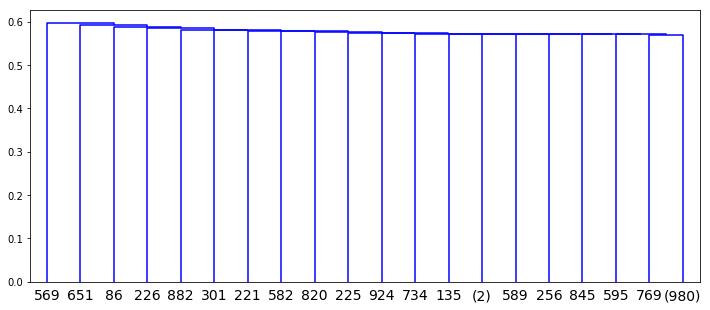

Corrida 0 - 'complete'


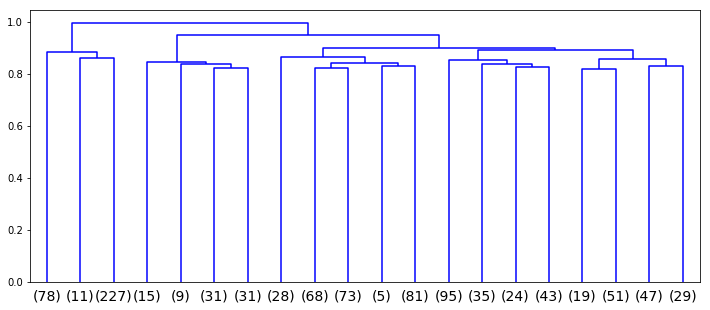

Corrida 0 - 'weighted'


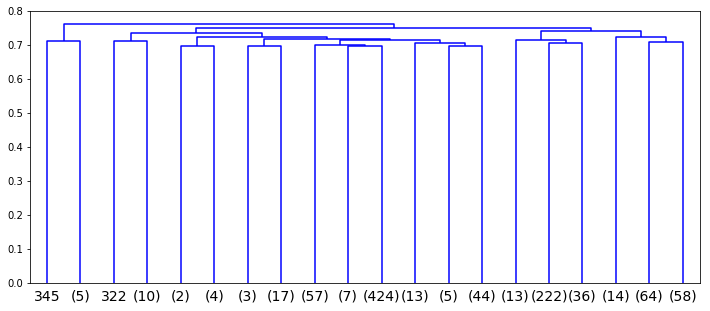

Corrida 1 - 'single'


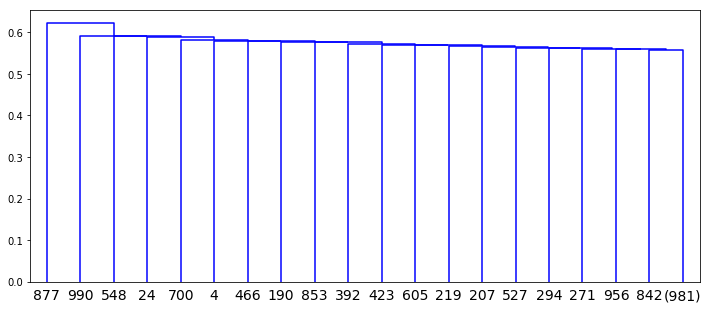

Corrida 1 - 'complete'


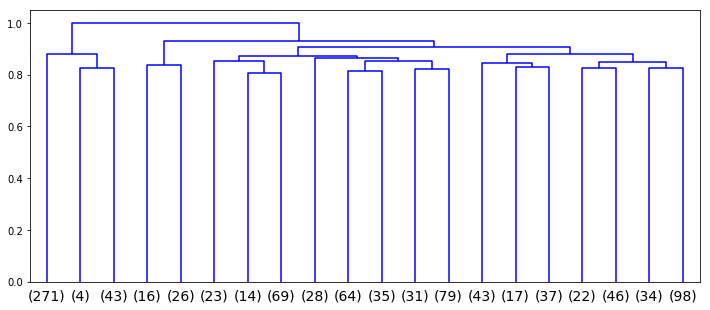

Corrida 1 - 'weighted'


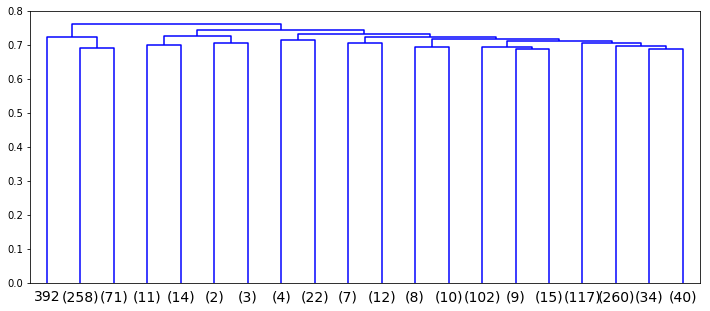

Corrida 2 - 'single'


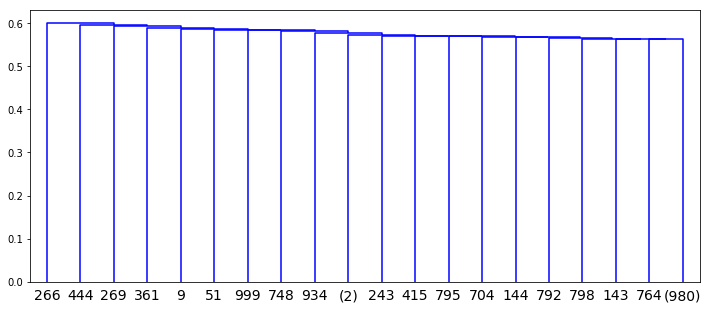

Corrida 2 - 'complete'


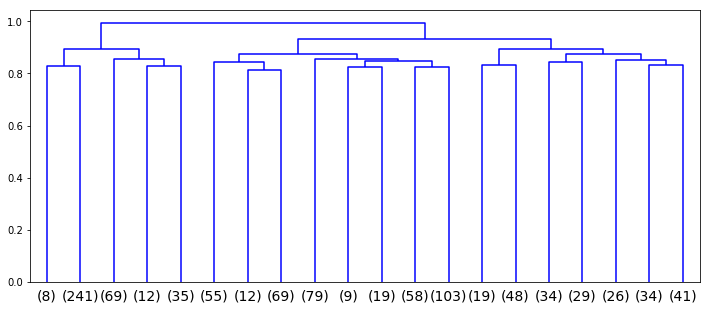

Corrida 2 - 'weighted'


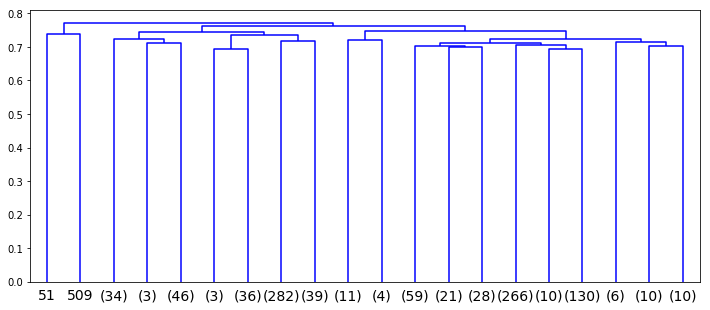

Corrida 3 - 'single'


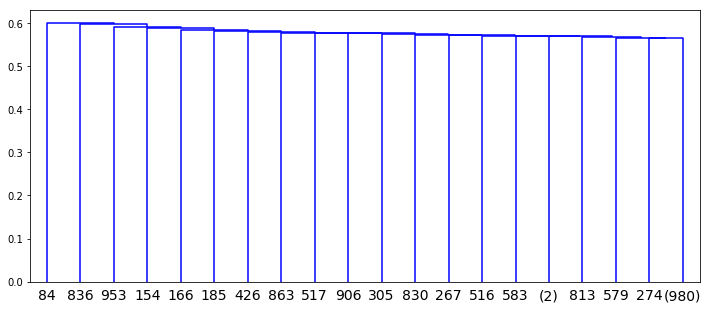

Corrida 3 - 'complete'


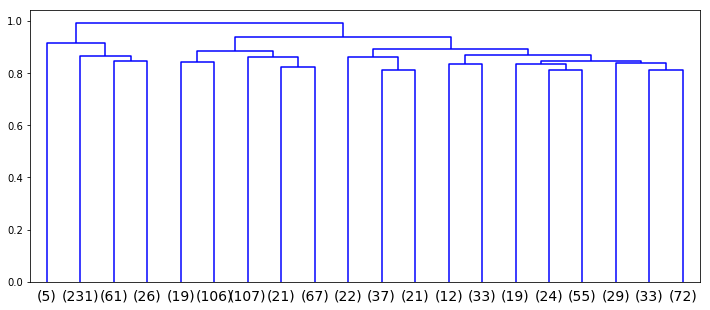

Corrida 3 - 'weighted'


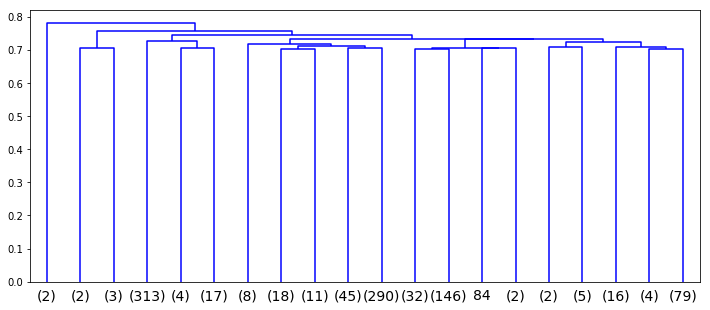

Corrida 4 - 'single'


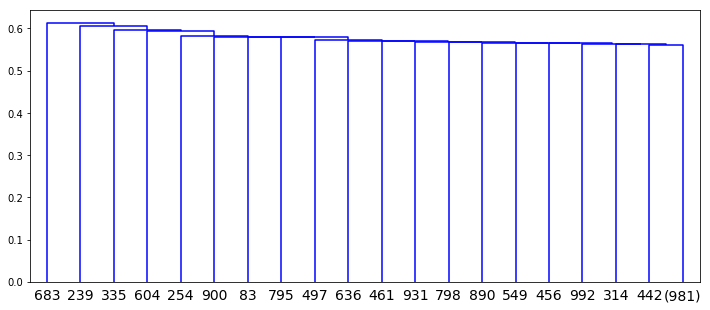

Corrida 4 - 'complete'


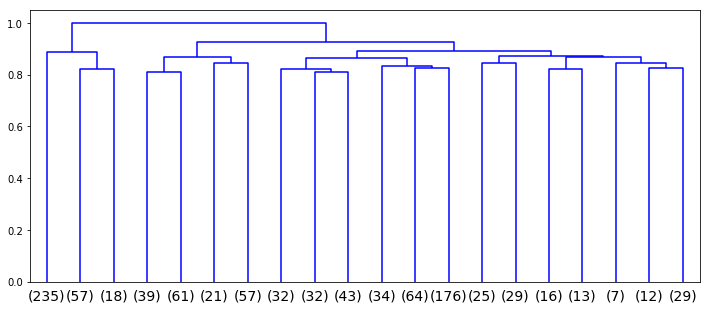

Corrida 4 - 'weighted'


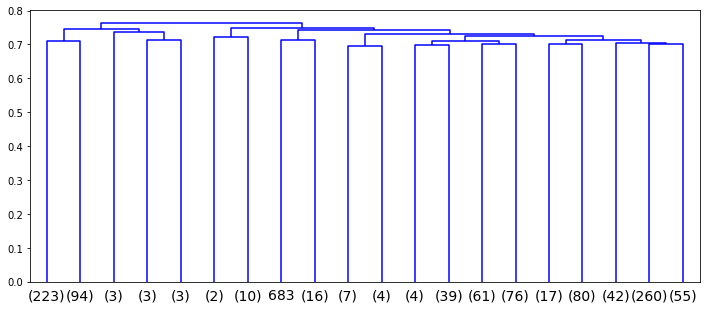

Corrida 5 - 'single'


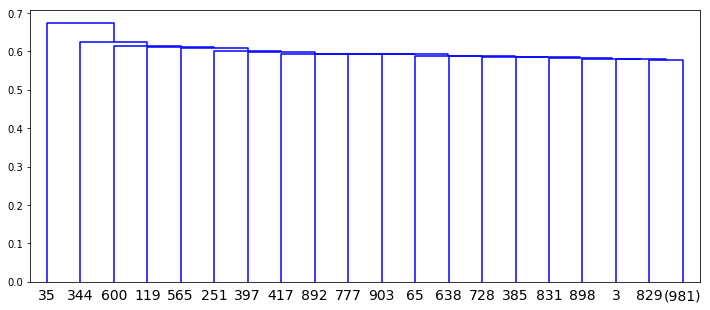

Corrida 5 - 'complete'


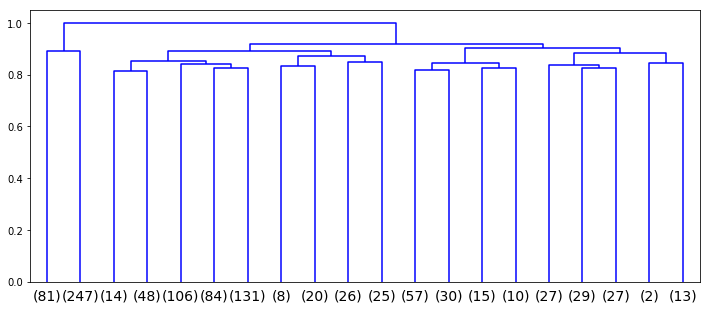

Corrida 5 - 'weighted'


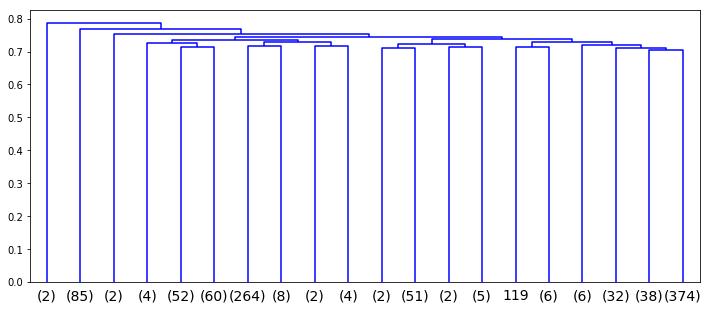

In [7]:
for i in range(6):
    df1 = df.sample(n=1000).reset_index(drop=True)
    X = distance_matrix(df1)
    corrida = "Corrida " + str(i)
    
    print(str(corrida) + " - " + "'single'")
    display_tree(X, 'single', 20)
    display(HTML('<hr style="border-width: 3px;">'))
    print(str(corrida) + " - " + "'complete'")
    display_tree(X, 'complete', 20)
    display(HTML('<hr style="border-width: 3px;">'))
    print(str(corrida) + " - " + "'weighted'")
    display_tree(X, 'weighted', 20)
    display(HTML('<hr style="border-width: 5px;"><br><br>'))

<div style="margin-top: 6px; border: 1px solid #cfcfcf; padding: 8px 12px; border-radius:2px; background-color:#f7f7f7;">
A este nuevo nivel. podemos distinguir 4 o 5 potenciales grupos. 
<br>Estos resultados nos "dan una idea" de cuantos agrupamientos pudiéramos buscar.
</div>